# Medical Cost Dataset

## Description
The Medical Cost Dataset contains demographic and health-related features of patients, such as age, BMI, smoking habit, number of children, region, etc., along with their corresponding medical costs.


## Attributes
- __Age__: Age of the patient (years)
- __Sex__: Gender of the patient (male or female)
- __BMI__: Body mass index ($\frac{\text{weight}}{\text{height}^2}$)
- __Children__: Number of children/dependents covered by health insurance
- __Smoker__: Smoking habit of the patient (yes or no)
- __Region__: Geographic region of the patient (northeast, southeast, southwest, northwest)
- __Charges__: Medical costs incurred by the patient


## Objective

The objective of this dataset is to perform a regression task to predict the medical costs incurred by patients based on their demographic and health-related features.

<hr/>
<small>

<strong>Ali Bozorgzadeh</strong> \<<a>https://abzrg.github.io</a>\> <br/>
<em>Mechanical Engineer</em> <br/>
<em>Babol Noshirvani Univeristy of Technology</em>
</small>
<hr/>


## Import necessary packages and apply some settings

In [1]:
# Suppress all warning messages to have an uncluttered output
import warnings

warnings.filterwarnings("ignore")

# Bunch of little helper utilities to reduce the code size in this notebook
import utils  # ./utils.py

# Check if it runs on google colab or kaggle
roc = utils.is_running_on_cloud()

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Packages that provide regression models
import sklearn

if roc:
    import xgboost

# Use viridis color pallete
sns.set_palette("viridis")

# Allow histplot to accept edgecolor
plt.rcParams["patch.force_edgecolor"] = True

# Higher quality plot images
%matplotlib inline
%config InlineBackend.figure_format = "svg"

# Check the version of libraries
utils.print_lib_versions(np, pd, matplotlib, sns, sklearn)
if roc:
    utils.print_lib_versions(xgboost)

numpy:       1.26.4
pandas:      2.2.0
matplotlib:  3.8.3
seaborn:     0.13.2
sklearn:     1.4.1.post1


# Exploratory Data Analysis (EDA)

## Loading data

In [2]:
insur = pd.read_csv("./insurance.csv")

## Inspecting data


Firstly we take a look at a first few rows of our data


In [3]:
insur.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


and its shape

In [4]:
insur.shape

(1338, 7)

We can take a look at unique values in the string (of type `object`) columns:

In [5]:
utils.print_unique_column_entries(insur.select_dtypes("object"))

Unique values for sex, smoker, region:
- sex (2): ('female', 'male')
- smoker (2): ('yes', 'no')
- region (4): ('southwest', 'southeast', 'northwest', 'northeast')


Next up, we'll look at a concise summary of the data


In [6]:
insur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


So it shows us:

- there are _1338_ examples,
- there a total of of 7 columns, where three of which is of type string (`object`), two integers (`int64`) and two floats (`float64`),
- and most notably, there is no missing (null) value in our data.

We can ensure that there's no missing value with the following code snippet:


In [7]:
missing_count = insur.isnull().sum().sum()
print(f"{missing_count = }")

missing_count = 0


### Stats

Indeed there was none, and can move on and skip dropping null values. Next, we'll have a look at some statistics of the data.

In [8]:
utils.describe(insur)

,count,mean,std,min,25%,50%,75%,max
age,1338.000000,39.207025,14.049960,18.000000,27.000000,39.000000,51.000000,64.000000
bmi,1338.000000,30.663397,6.098187,15.960000,26.296250,30.400000,34.693750,53.130000
children,1338.000000,1.094918,1.205493,0.000000,0.000000,1.000000,2.000000,5.000000
charges,1338.000000,13270.422265,12110.011237,1121.873900,4740.287150,9382.033000,16639.912515,63770.428010


### Skewness

In [9]:
print(f"Skewness of 'charges' column: {insur['charges'].skew():.2f}")

Skewness of 'charges' column: 1.52


As the value is greater than zero, the distribution of medical charges is _positively skewed_ (right-skewed), i.e., the right tail of the distribution is longer or fatter than the left tail.
This suggests that the majority of patients may have lower medical costs, but there is a relatively small subset of patients with significantly higher charges, contributing to the positive skewness.

#### Distribution plot

We can check this by plotting the distribution

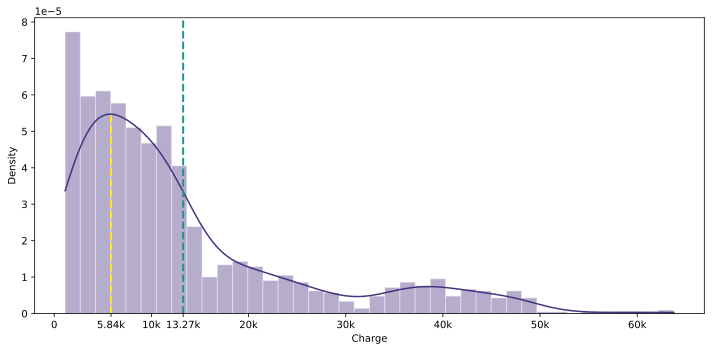

In [10]:
utils.plot_charges_distribution(insur["charges"])

The plot shows both a histogram and a distribution curve of medical charges. 
The yellow vertical line indicates the location of the <span style="color: black; background-color: #fde725;">mode</span> of the distribution, and the green one represents the location of the <span style="color: white; background-color: #21918c;">mean</span>.

# Process data

Now, considering that we have string columns like `sex`, `smoker`, and `regions`, we need to encode
them into some numerical values, so that they can be used to train a machine learning model.
For the `sex` and `smoker` we can use _binary encoding_ to set the data to either `0` (female, no) and `1` (male, yes), as they have only two values. For the `region` we can use the _[one-hot encoding](https://en.wikipedia.org/wiki/One-hot)_ to replace the regions column with four regions columns. 

In [11]:
insur_proccessed = utils.preprocess_data(insur)
insur_proccessed.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Now we have all the columns as numeric values.

Next we will take a look at how these variables correlate with each other.

In [12]:
insur_proccessed.corr()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.002425,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,-0.002425,-0.138156,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


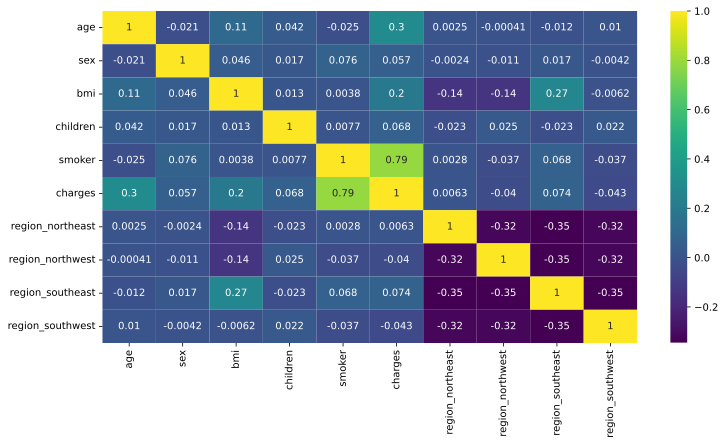

In [13]:
plt.figure(figsize=(12, 6))
sns.heatmap(insur_proccessed.corr(), annot=True, cmap="viridis")
plt.show()

Looking at this plot, we can see that:

- There is a positive correlation of approximately `0.30` between _age_ and insurance charges. This suggests that as a person's age increases, their insurance charges tend to increase as well.
- There is a __strong positive correlation__ of approximately `0.79` between being a _smoker_ and insurance charges. This indicates that smokers tend to have significantly higher insurance charges compared to non-smokers.
- The correlation between BMI (Body Mass Index) and insurance charges is around `0.20`, suggesting a moderate positive relationship. This implies that individuals with higher BMI may have higher insurance charges on average.
- The correlation coefficients for the regions (northeast, northwest, southeast, southwest) with charges are relatively low. This indicates a weak linear relationship between the region and insurance charges.

Other things that can be done, but I don't know, for now, how to implement:

- detecting outliers and handling them
- feature engineering

# Feature selection/engineering

We could remove the region coloumns.

# Training

First we split the data into input and targets

In [14]:
y = insur_proccessed["charges"]
X = insur_proccessed.drop("charges", axis=1)

Next, we'll split the data into training and test subsets

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=2048
)

In [16]:
utils.describe(X_train)

,count,mean,std,min,25%,50%,75%,max
age,1070.000000,39.453271,13.896354,18.000000,27.000000,40.000000,51.000000,64.000000
sex,1070.000000,0.506542,0.500191,0.000000,0.000000,1.000000,1.000000,1.000000
bmi,1070.000000,30.710252,6.111396,15.960000,26.296250,30.495000,34.770000,53.130000
children,1070.000000,1.135514,1.228501,0.000000,0.000000,1.000000,2.000000,5.000000
smoker,1070.000000,0.213084,0.409678,0.000000,0.000000,0.000000,0.000000,1.000000
region_northeast,1070.000000,0.236449,0.425099,0.000000,0.000000,0.000000,0.000000,1.000000
region_northwest,1070.000000,0.242991,0.429090,0.000000,0.000000,0.000000,0.000000,1.000000
region_southeast,1070.000000,0.278505,0.448473,0.000000,0.000000,0.000000,1.000000,1.000000
region_southwest,1070.000000,0.242056,0.428528,0.000000,0.000000,0.000000,0.000000,1.000000


The values of mean, std, min etc., are spread in wide range of values.
Thus, we need to first scale them.

## Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [18]:
utils.describe(X_train)

,count,mean,std,min,25%,50%,75%,max
age,1070.000000,0.466375,0.302095,0.000000,0.195652,0.478261,0.717391,1.000000
sex,1070.000000,0.506542,0.500191,0.000000,0.000000,1.000000,1.000000,1.000000
bmi,1070.000000,0.396832,0.164417,0.000000,0.278080,0.391041,0.506053,1.000000
children,1070.000000,0.227103,0.245700,0.000000,0.000000,0.200000,0.400000,1.000000
smoker,1070.000000,0.213084,0.409678,0.000000,0.000000,0.000000,0.000000,1.000000
region_northeast,1070.000000,0.236449,0.425099,0.000000,0.000000,0.000000,0.000000,1.000000
region_northwest,1070.000000,0.242991,0.429090,0.000000,0.000000,0.000000,0.000000,1.000000
region_southeast,1070.000000,0.278505,0.448473,0.000000,0.000000,0.000000,1.000000,1.000000
region_southwest,1070.000000,0.242056,0.428528,0.000000,0.000000,0.000000,0.000000,1.000000


Now, values are more close to each other. For example, means are all close to 0, and standard deviations close to 1.

# Model Selection

Here we'll pick some regression models of various kind and will train them.

In [19]:
# Various machine learning models
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeCV,
    LassoCV,
    ElasticNetCV,
)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

if roc:
    from xgboost import XGBRegressor

In [20]:
# fmt: off

models: dict[str, sklearn.base.BaseEstimator] = {
    "          OLS Model": LinearRegression(),
    "           L2 Model": Ridge(),
    "           L1 Model": Lasso(),
    "   ElasticNet Model": ElasticNet(),
    "        L2 CV Model": RidgeCV(),
    "        L1 CV Model": LassoCV(),
    " ElasticNetCV Model": ElasticNetCV(),
    "      Random Forest": RandomForestRegressor(),
    "  Gradient Boosting": GradientBoostingRegressor(),
    "K-Neafest Neighbors": KNeighborsRegressor(),
}

# fmt: on

if roc:
    models[" XG Boost Regressor"] = XGBRegressor(random_state=2048)

In [21]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name, "trained")

          OLS Model trained
           L2 Model trained
           L1 Model trained
   ElasticNet Model trained
        L2 CV Model trained
        L1 CV Model trained


 ElasticNetCV Model trained
      Random Forest trained
  Gradient Boosting trained
K-Neafest Neighbors trained


# Model Evaluation

To assess the results of these models, we'll utilize the $R^2$ _score_, as it is a very important metric that is used to evaluate the performance of a regression-based machine learning model.

In [22]:
for name, model in models.items():
    print(f"{name}: R^2 Score: {model.score(X_test, y_test):.5f}")

          OLS Model: R^2 Score: 0.72713
           L2 Model: R^2 Score: 0.72890
           L1 Model: R^2 Score: 0.72779
   ElasticNet Model: R^2 Score: 0.29390
        L2 CV Model: R^2 Score: 0.72781
        L1 CV Model: R^2 Score: 0.72812
 ElasticNetCV Model: R^2 Score: 0.02952
      Random Forest: R^2 Score: 0.82142
  Gradient Boosting: R^2 Score: 0.83962
K-Neafest Neighbors: R^2 Score: 0.73632


The evaluation of various machine learning models on the dataset yields insightful $R^2$ scores.
- _Ordinary Least Squares (OLS)_, _L2 regularization_, and _L1 regularization demonstrate_ comparable performance, with $R^2$ scores around __0.73__.
- _ElasticNet_, however, exhibits a significantly lower $R^2$ score of _0.29_, suggesting a weaker fit to the data.
- _Cross-validated_ versions of L2 and L1 models show marginal improvements, reinforcing the stability of their predictive capabilities.
- Surprisingly, _ElasticNetCV_ performs notably worse than its non-cross-validated counterpart, emphasizing the importance of model selection.
- Among the ensemble methods, _Random Forest_ and <span style="color: black; background-color: #fde725;">Gradient Boosting</span> display superior performance, achieving $R^2$ scores of _0.83_ and <span style="color: black; background-color: #fde725;">0.84</span>, respectively.
- _K-Nearest Neighbors_, while respectable with an $R^2$ score of _0.74_, falls slightly short of the predictive power demonstrated by the ensemble methods.

These results underline the effectiveness of ensemble techniques, particularly _Gradient Boosting_, in capturing the underlying patterns within the dataset.

# Hyper Parameter tuning

Thus far we've use the default values for each of the above models. To find the best hyperparameters for each model, we use the _Grid Search tehcnique_.

The following dictionary defines the hyperparameter grids for each model.

In [23]:
# fmt: off
param_grids = {
    "          OLS Model": {},
    "           L2 Model": {"alpha": [0.1, 1, 10]},
    "           L1 Model": {"alpha": [0.1, 1, 10]},
    "   ElasticNet Model": {"alpha": [0.1, 1, 10], "l1_ratio": [0.1, 0.5, 0.9]},
    "        L2 CV Model": {"alphas": [(0.1, 1.0, 10.0)]},
    "        L1 CV Model": {"alphas": [(0.1, 1.0, 10.0)]},
    " ElasticNetCV Model": {"alphas": [(0.1, 1.0, 10.0)], "l1_ratio": [0.1, 0.5, 0.9]},
    "      Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
    "  Gradient Boosting": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7]},
    "K-Neafest Neighbors": {"n_neighbors": [3, 5, 10]},
}
# fmt: on

if roc:
    param_grids[" XG Boost Regressor"] = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "reg_alpha": [0.01, 0.1, 1.0],
        "reg_lambda": [0.01, 0.1, 1.0],
    }

In the provided code, the values specified in the hyperparameter grids for each model represent the potential values that the Grid Search algorithm will explore to find the combination that yields the best performance. 

1. **Ridge and Lasso Models:**
   - `alpha`: This parameter controls the regularization strength. The values `[0.1, 1, 10]` are commonly used for testing different levels of regularization.

2. **ElasticNet Model:**
   - `alpha`: Similar to Ridge and Lasso, controlling overall regularization strength.
   - `l1_ratio`: This parameter determines the mix of L1 and L2 regularization. The values `[0.1, 0.5, 0.9]` cover a range from mostly L2 regularization to mostly L1 regularization.

3. **Random Forest and Gradient Boosting:**
   - `n_estimators`: The number of trees in the ensemble. `[50, 100, 200]` tests different sizes of ensembles.
   - `max_depth`: The maximum depth of each tree. `[None, 10, 20]` explores different tree depths.

4. **K-Nearest Neighbors:**
   - `n_neighbors`: The number of neighbors to consider. `[3, 5, 10]` explores different numbers of neighbors.

The selection of these values is somewhat arbitrary and based on common practices. The idea is to test a range of values to ensure that the Grid Search algorithm explores a diverse set of hyperparameter combinations. The specific values can depend on the characteristics of the data, the nature of the problem, and some trial and error.


The way it works is that, Grid Search exhaustively tests all possible combinations of hyperparameter values from the provided grids using cross-validation. It selects the combination that maximizes the specified scoring metric (in this case, R^2 score) on the validation sets during cross-validation.

It's worth noting that these values might not be optimal for every dataset or problem. Fine-tuning hyperparameters often requires domain knowledge, experimentation, and a deeper understanding of the specific characteristics of the data.

In [24]:
best_models, performance_log = utils.compute_best_models(
    models, param_grids, X_train, y_train, verbose=4
)

for log in performance_log:
    print(log)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.715 total time=   0.0s
[CV 2/5] END ..................................., score=0.748 total time=   0.0s
[CV 3/5] END ..................................., score=0.780 total time=   0.0s
[CV 4/5] END ..................................., score=0.755 total time=   0.0s
[CV 5/5] END ..................................., score=0.751 total time=   0.0s
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .........................alpha=0.1;, score=0.715 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.748 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.780 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.755 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.751 total time=   0.0s
[CV 1/5] END ...........................alpha=1;, score=0.715 total tim

[CV 2/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.644 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.642 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.651 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.1;, score=0.624 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.657 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.703 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.709 total time=   0.0s
[CV 4/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.706 total time=   0.0s
[CV 5/5] END ...........alpha=0.1, l1_ratio=0.5;, score=0.687 total time=   0.0s
[CV 1/5] END ...........alpha=0.1, l1_ratio=0.9;, score=0.710 total time=   0.0s
[CV 2/5] END ...........alpha=0.1, l1_ratio=0.9;, score=0.749 total time=   0.0s
[CV 3/5] END ...........alpha=0.1, l1_ratio=0.9;, score=0.771 total time=   0.0s
[CV 4/5] END ...........alph

The evaluation of various machine learning models, along with the determination of their optimal hyperparameters, provides valuable insights into their performance on the dataset.

- Notably, <span style="color: black; background-color: #fde725;">Gradient Boosting</span> emerges as the top-performing model, achieving the highest $R^2$ score of <span style="color: black; background-color: #fde725;">0.85995</span> with optimal hyperparameters <span style="color: black; background-color: #fde725;"><tt>{'max_depth': 3, 'n_estimators': 50}`</tt></span>.
- _Random Forest_ also demonstrates strong performance, securing the second-highest $R^2$ score of 0.84018 with `{'max_depth': 10, 'n_estimators': 200}`.
- The traditional linear models (OLS, L2, L1) and their cross-validated counterparts exhibit comparable $R^2$ scores around 0.75, showcasing their robustness.
- K-Nearest Neighbors, with `{'n_neighbors': 5}`, delivers a respectable $R^2$ score of 0.75148.
- ElasticNet and ElasticNetCV achieve similar $R^2$ scores of 0.74488, with the latter incorporating cross-validation.

It is noteworthy that Gradient Boosting and Random Forest outperform the linear models, emphasizing the dataset's complexity and the effectiveness of ensemble techniques.

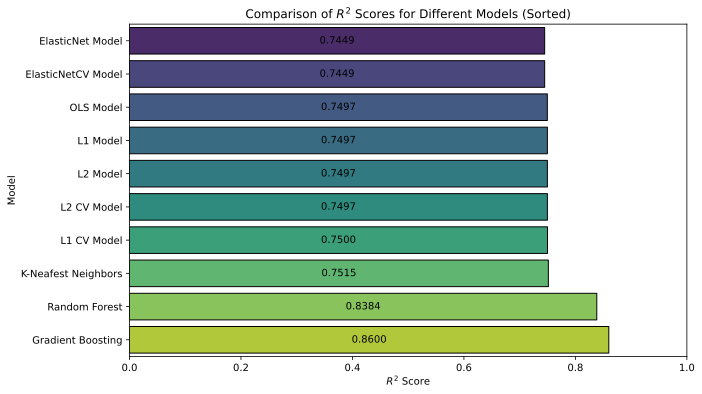

In [25]:
utils.plot_best_models(best_models)

# Model Interpretation

Now, we move on with our best model, Gradient Boosting. In order to interpret and understand the result, we need to understand the impact of different features on the predicted charges.

We can examine the feature importance scores from the trained Gradient Boosting model.

In [26]:
best_model = best_models["  Gradient Boosting"][0]
best_model.feature_importances_

array([1.11003746e-01, 5.52169768e-06, 1.80177703e-01, 6.58185712e-03,
       6.98797286e-01, 1.94538851e-03, 5.74383511e-04, 1.54787130e-04,
       7.59326747e-04])

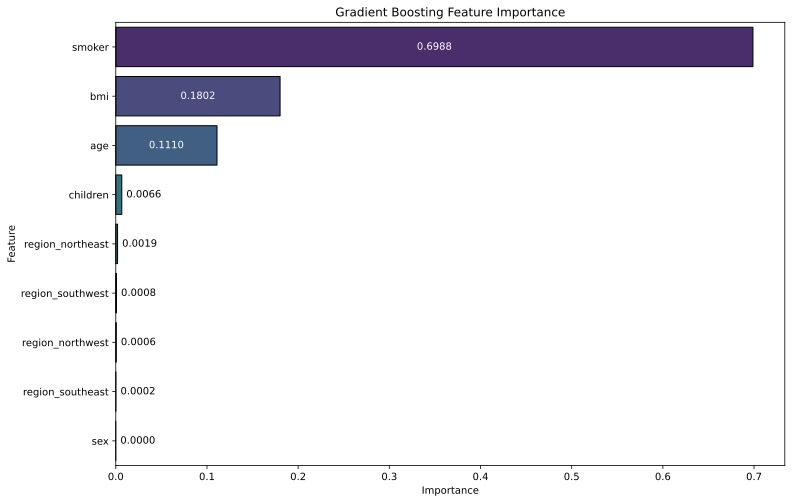

In [27]:
utils.plot_feature_importance(best_model=best_model, feature_names=X_train.columns)

The feature importance scores obtained from the Gradient Boosting model offer valuable insights into the factors influencing the prediction of medical costs. The most impactful feature, with a significantly higher importance score of approximately <span style="color: black; background-color: #fde725;">0.70</span>, is <span style="color: black; background-color: #fde725;">"smoker"</span>. This suggests that smoking status is a dominant factor in determining medical costs, with smokers incurring substantially higher expenses than non-smokers.

Following in importance is "bmi" (body mass index) at approximately 0.18, highlighting its relevance in predicting medical costs. The remaining features, including "age," "children," and "region," contribute to a lesser extent, each with importance scores below 0.12. Interestingly, the feature "sex" holds the least importance, with a negligible score close to zero.

These results underscore the significance of lifestyle choices, particularly smoking habits and BMI, in shaping the variation in medical costs within the dataset. Understanding these influential factors is crucial for both medical practitioners and policymakers aiming to make informed decisions related to healthcare costs and interventions.

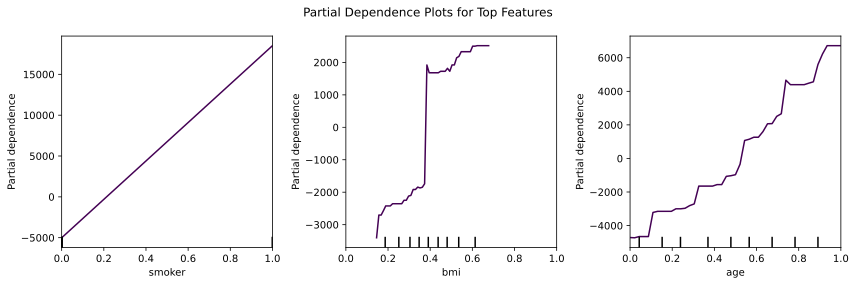

In [55]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming best_model is your trained Gradient Boosting model
top_features = ["smoker", "bmi", "age"]

# Create PartialDependenceDisplay for the top features
fig, axs = plt.subplots(
    1, len(top_features), figsize=(12, 4), sharey=True
)  # sharey=True Does not work. bloody sklearn

for i, feature in enumerate(top_features):
    display = PartialDependenceDisplay.from_estimator(
        best_models["  Gradient Boosting"][0],
        X_train,
        features=[feature],
        grid_resolution=50,
        ax=axs[i],
        line_kw={"color": "#440154"},
        kind="average",
    )
    display.axes_[0][0].set_xlim(0.0, 1.0)
axs[0].set_ylabel("Partial Dependence")  # Does not work. bloody sklearn
plt.suptitle("Partial Dependence Plots for Top Features")
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()

"""
Not sure why the range of values for bmi is somewhere between 0.1 and 0.7...
"""

Things to learn more about:

- Hypertuning techniques: Grid search etc.
- Model evaluation measure: r2 score, mean square error? (`sklearn.metrics`)
    - https://www.youtube.com/watch?v=Lky_OGhKT4I
    - Q: why the values of score changes for each fit of the model?
- partial dependency plot (PDP plot)
    - https://www.youtube.com/watch?v=BgUMI8_oSRI
- each of the models
